In [112]:
# Import Libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.layers import LeakyReLU, PReLU, ELU
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [113]:
# seaborn settings for visualization
rc = {
    "axes.facecolor": "#f7f9fc",
    "figure.facecolor": "#f7f9fc",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

default_palette='YlOrRd'

sns.set_theme(style="whitegrid",rc=rc,palette=default_palette)
pd.set_option('display.max_columns',35)
pd.options.display.float_format='{:,.2f}'.format



In [114]:
pwd

'/home/anushka/Documents/kaggle-Playground-Series/S4E2'

In [115]:
# import data
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')
orginal=pd.read_csv('ObesityDataSet.csv')

In [116]:
print(f"Train dataset has {df_train.shape[0]} rows and {df_train.shape[1]} columns")
print(f"Test dataset has {df_test.shape[0]} rows and {df_test.shape[1]} columns")

Train dataset has 20758 rows and 18 columns
Test dataset has 13840 rows and 17 columns


In [117]:
# Lets check the samples of the data
display('Train',df_train.head())
display('Test',df_test.head())

'Train'

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.44,1.70,81.67,yes,yes,2.00,2.98,Sometimes,no,2.76,no,0.00,0.98,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.00,1.56,57.00,yes,yes,2.00,3.00,Frequently,no,2.00,no,1.00,1.00,no,Automobile,Normal_Weight
2,2,Female,18.00,1.71,50.17,yes,yes,1.88,1.41,Sometimes,no,1.91,no,0.87,1.67,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.95,1.71,131.27,yes,yes,3.00,3.00,Sometimes,no,1.67,no,1.47,0.78,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.64,1.91,93.80,yes,yes,2.68,1.97,Sometimes,no,1.98,no,1.97,0.93,Sometimes,Public_Transportation,Overweight_Level_II


'Test'

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.90,1.85,120.64,yes,yes,2.94,3.00,Sometimes,no,2.83,no,0.86,0.00,Sometimes,Public_Transportation
1,20759,Female,21.00,1.60,66.00,yes,yes,2.00,1.00,Sometimes,no,3.00,no,1.00,0.00,Sometimes,Public_Transportation
2,20760,Female,26.00,1.64,111.60,yes,yes,3.00,3.00,Sometimes,no,2.62,no,0.00,0.25,Sometimes,Public_Transportation
3,20761,Male,20.98,1.55,103.67,yes,yes,2.00,2.98,Sometimes,no,2.79,no,0.09,0.00,Sometimes,Public_Transportation
4,20762,Female,26.00,1.63,104.84,yes,yes,3.00,3.00,Sometimes,no,2.65,no,0.00,0.74,Sometimes,Public_Transportation


In [118]:
from tabulate import tabulate
data = [
    ["FAVC", "Frequent consumption of high caloric food"],
    ["FCVC", "Frequency of consumption of vegetables"],
    ["NCP", "Number of main meals"],
    ["CAEC", "Consumption of food between meals"],
    ["CH20", "Consumption of water daily"],
    ["CALC", "Consumption of alcohol"],
    ["SCC", "Calories consumption monitoring"],
    ["FAF", "Physical activity frequency"],
    ["TUE", "Time using technology devices"],
    ["MTRANS", "Transportation used"]
]
headers=['Feature','Description']
table=tabulate(data,headers,tablefmt='fancy_grid')
print(table)

╒═══════════╤═══════════════════════════════════════════╕
│ Feature   │ Description                               │
╞═══════════╪═══════════════════════════════════════════╡
│ FAVC      │ Frequent consumption of high caloric food │
├───────────┼───────────────────────────────────────────┤
│ FCVC      │ Frequency of consumption of vegetables    │
├───────────┼───────────────────────────────────────────┤
│ NCP       │ Number of main meals                      │
├───────────┼───────────────────────────────────────────┤
│ CAEC      │ Consumption of food between meals         │
├───────────┼───────────────────────────────────────────┤
│ CH20      │ Consumption of water daily                │
├───────────┼───────────────────────────────────────────┤
│ CALC      │ Consumption of alcohol                    │
├───────────┼───────────────────────────────────────────┤
│ SCC       │ Calories consumption monitoring           │
├───────────┼───────────────────────────────────────────┤
│ FAF       │ 

## Summary of the Data

In [119]:
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['Duplicate'] = df.duplicated().sum()
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['avg'] = desc['mean'].values
    summ['std dev'] = desc['std'].values
    summ['top value'] = desc['top'].values
    summ['Freq'] = desc['freq'].values

    return summ

In [120]:
summary(df_train.drop(columns=["id"]))

,data type,#missing,Duplicate,#unique,min,max,avg,std dev,top value,Freq
Gender,object,0,0,2,NaN,NaN,NaN,NaN,Female,10422
Age,float64,0,0,1703,14.00,61.00,23.84,5.69,NaN,NaN
Height,float64,0,0,1833,1.45,1.98,1.70,0.09,NaN,NaN
Weight,float64,0,0,1979,39.00,165.06,87.89,26.38,NaN,NaN
family_history_with_overweight,object,0,0,2,NaN,NaN,NaN,NaN,yes,17014
FAVC,object,0,0,2,NaN,NaN,NaN,NaN,yes,18982
FCVC,float64,0,0,934,1.00,3.00,2.45,0.53,NaN,NaN
NCP,float64,0,0,689,1.00,4.00,2.76,0.71,NaN,NaN
CAEC,object,0,0,4,NaN,NaN,NaN,NaN,Sometimes,17529
SMOKE,object,0,0,2,NaN,NaN,NaN,NaN,no,20513


## Exploratory Data Anylysis

In [121]:
def showplot(column_name):
    plt.rcParams['figure.facecolor']='white'
    plt.rcParams['axes.facecolor']='white'
    fig,ax=plt.subplots(1,2,figsize=(12,4))
    ax=ax.flatten()
    value_counts=df_train[column_name].value_counts()
    labels = value_counts.index.tolist()
    colors=["#4caba4", "#d68c78",'#a3a2a2','#ab90a0', '#e6daa3', '#6782a8', '#8ea677']

    # Donut chart
    wedges,texts,autotexts=ax[0].pie(value_counts,
                                     autopct="%1.1f%%",
                                     textprops={'size':9,'color':'white','fontweight':'bold'},
                                     colors=colors,
                                     wedgeprops=dict(width=0.35),
                                     startangle=80,
                                     pctdistance=0.85)
    # circle
    centre_circle=plt.Circle((0,0),0.6,fc='white')
    ax[0].add_artist(centre_circle)

    # count plot
    sns.countplot(data=df_train,y=column_name,ax=ax[1],palette=colors,order=labels)
    for index, value in enumerate(value_counts):
        ax[1].text(value+1,index,str(value),color='black',fontsize=10,va='center')
    sns.despine(left=True,bottom=True)
    plt.yticks(fontsize=9, color='black')
    ax[1].set_ylabel(None)
    plt.xlabel("")
    plt.xticks([])
    fig.suptitle(column_name,fontsize=15,fontweight='bold')
    plt.tight_layout(rect=[0,0,0.85,1])
    plt.show()


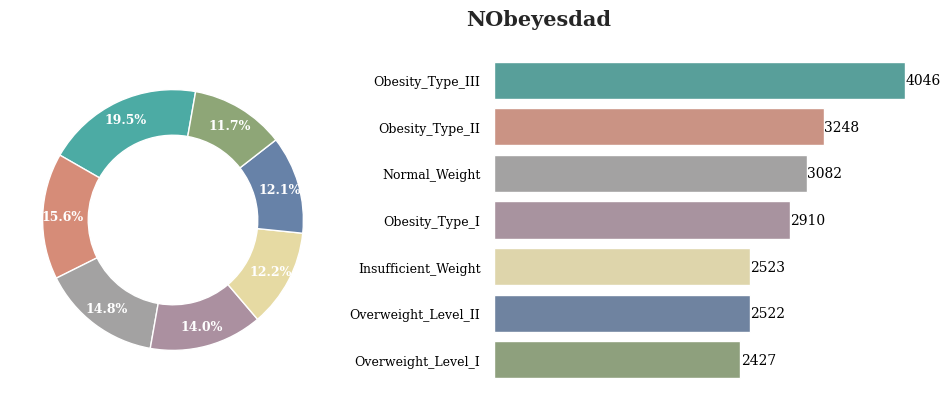

In [122]:
showplot('NObeyesdad')

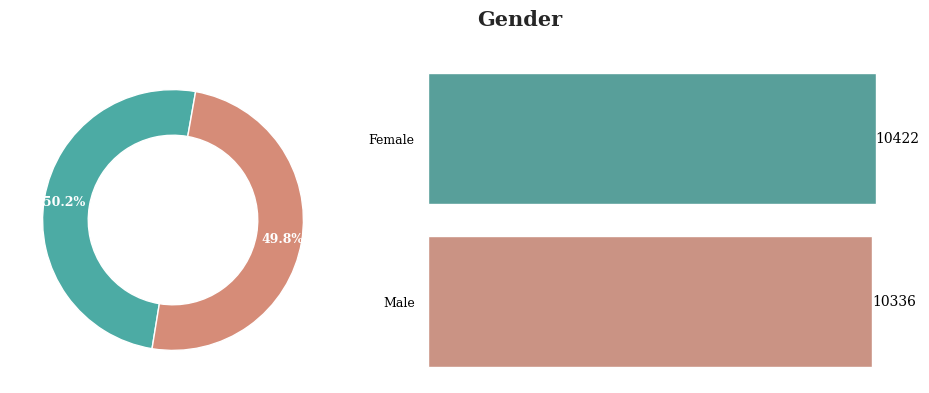

In [123]:
showplot('Gender')

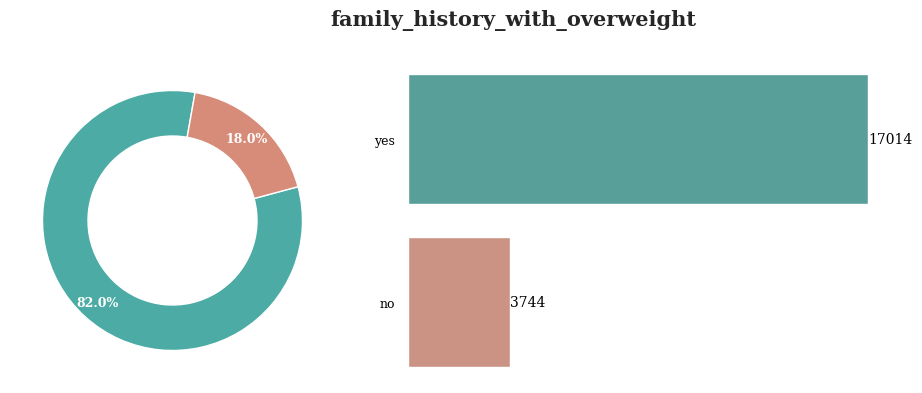

In [124]:
showplot("family_history_with_overweight")

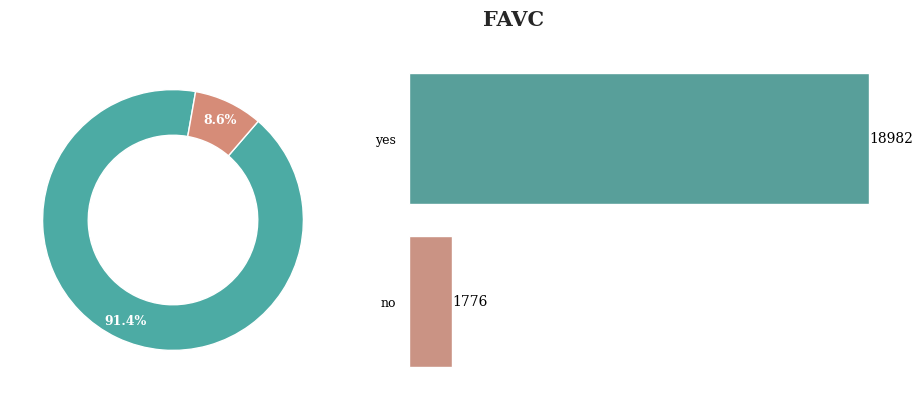

In [125]:
showplot("FAVC")

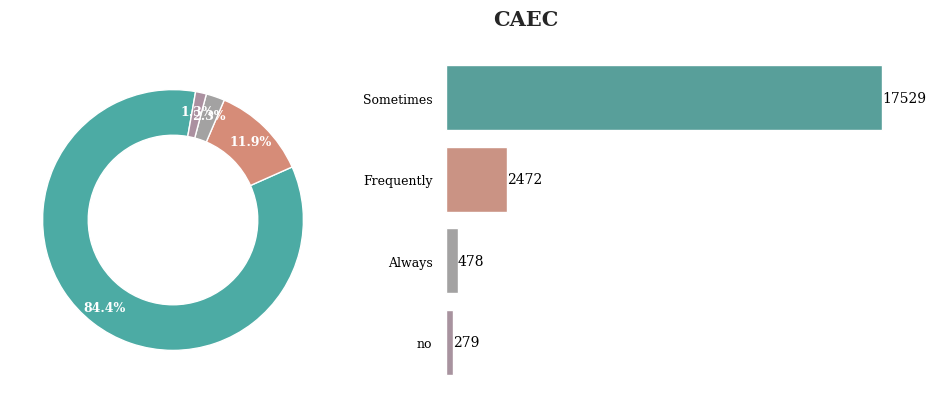

In [126]:
showplot("CAEC")

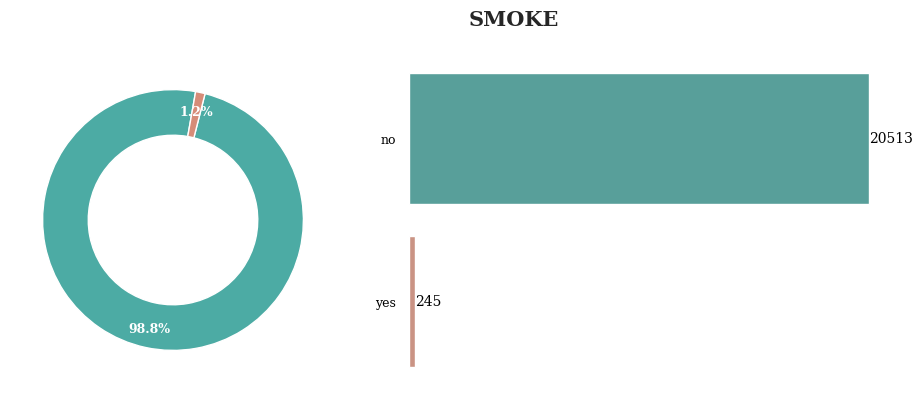

In [127]:
showplot("SMOKE")

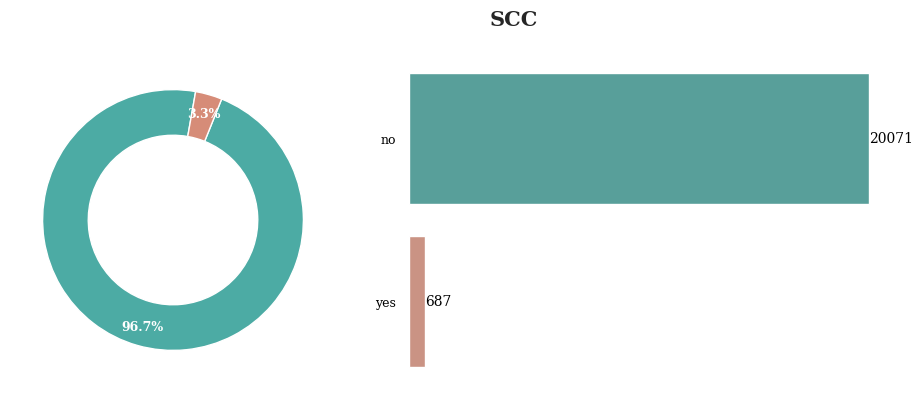

In [128]:
showplot("SCC")

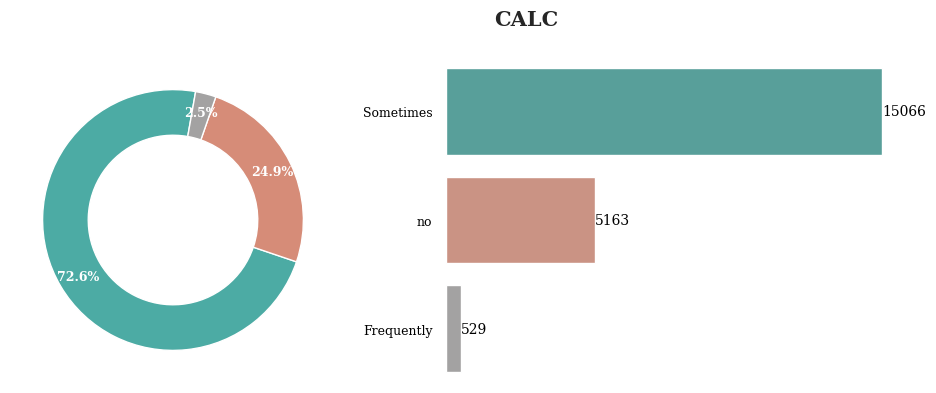

In [129]:
showplot("CALC")

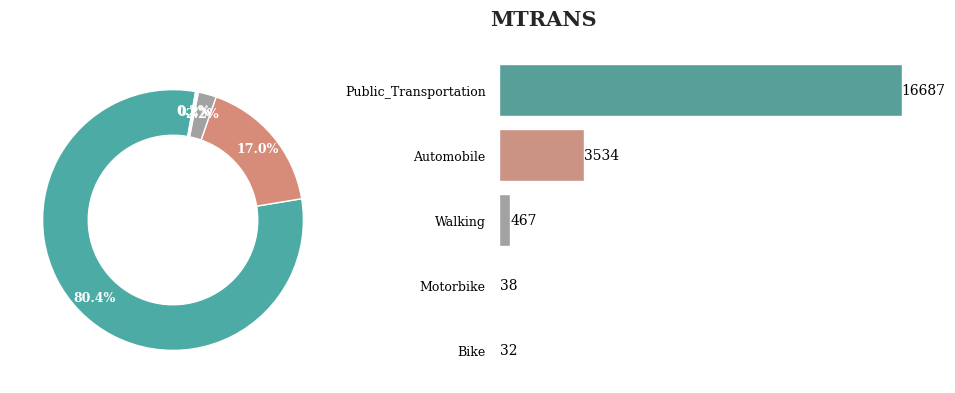

In [130]:
showplot("MTRANS")

In [131]:
# Checking for distributions
numeric_columns=df_train.select_dtypes(include=['float64','int64']).drop(columns=['id'],axis=1)

def dist_custom(dataset,columns_list,rows,columns):
    fig,axs=plt.subplots(rows,columns,figsize=(20,8))
    plt.suptitle('Distribution for Numerical features',fontsize=16,fontweight='bold')
    axs=axs.flatten()
    for i,data in enumerate(columns_list):
        sns.kdeplot(dataset[data],ax=axs[i],fill=True,alpha=0.8,color='#4caba4',linewidth=0)
        axs[i].set_title(data+', Skewness is '+str(round(dataset[data].skew(axis=0,skipna=True),2)))
    plt.tight_layout()

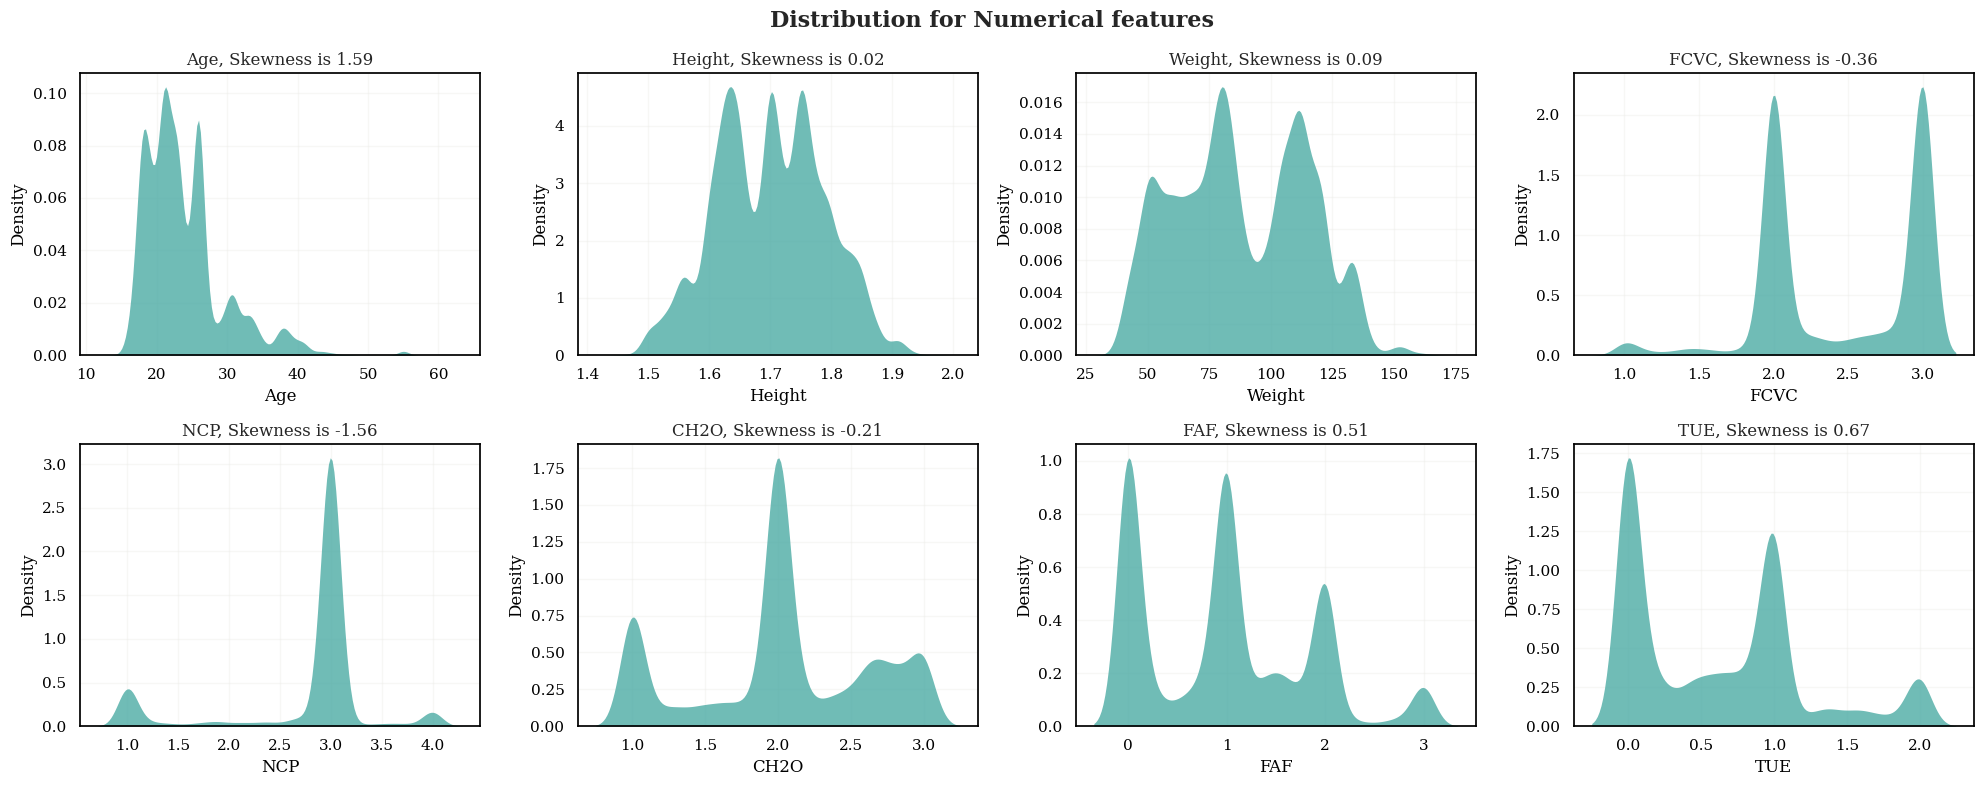

In [132]:
dist_custom(dataset=df_train,columns_list=numeric_columns,rows=2,columns=4)


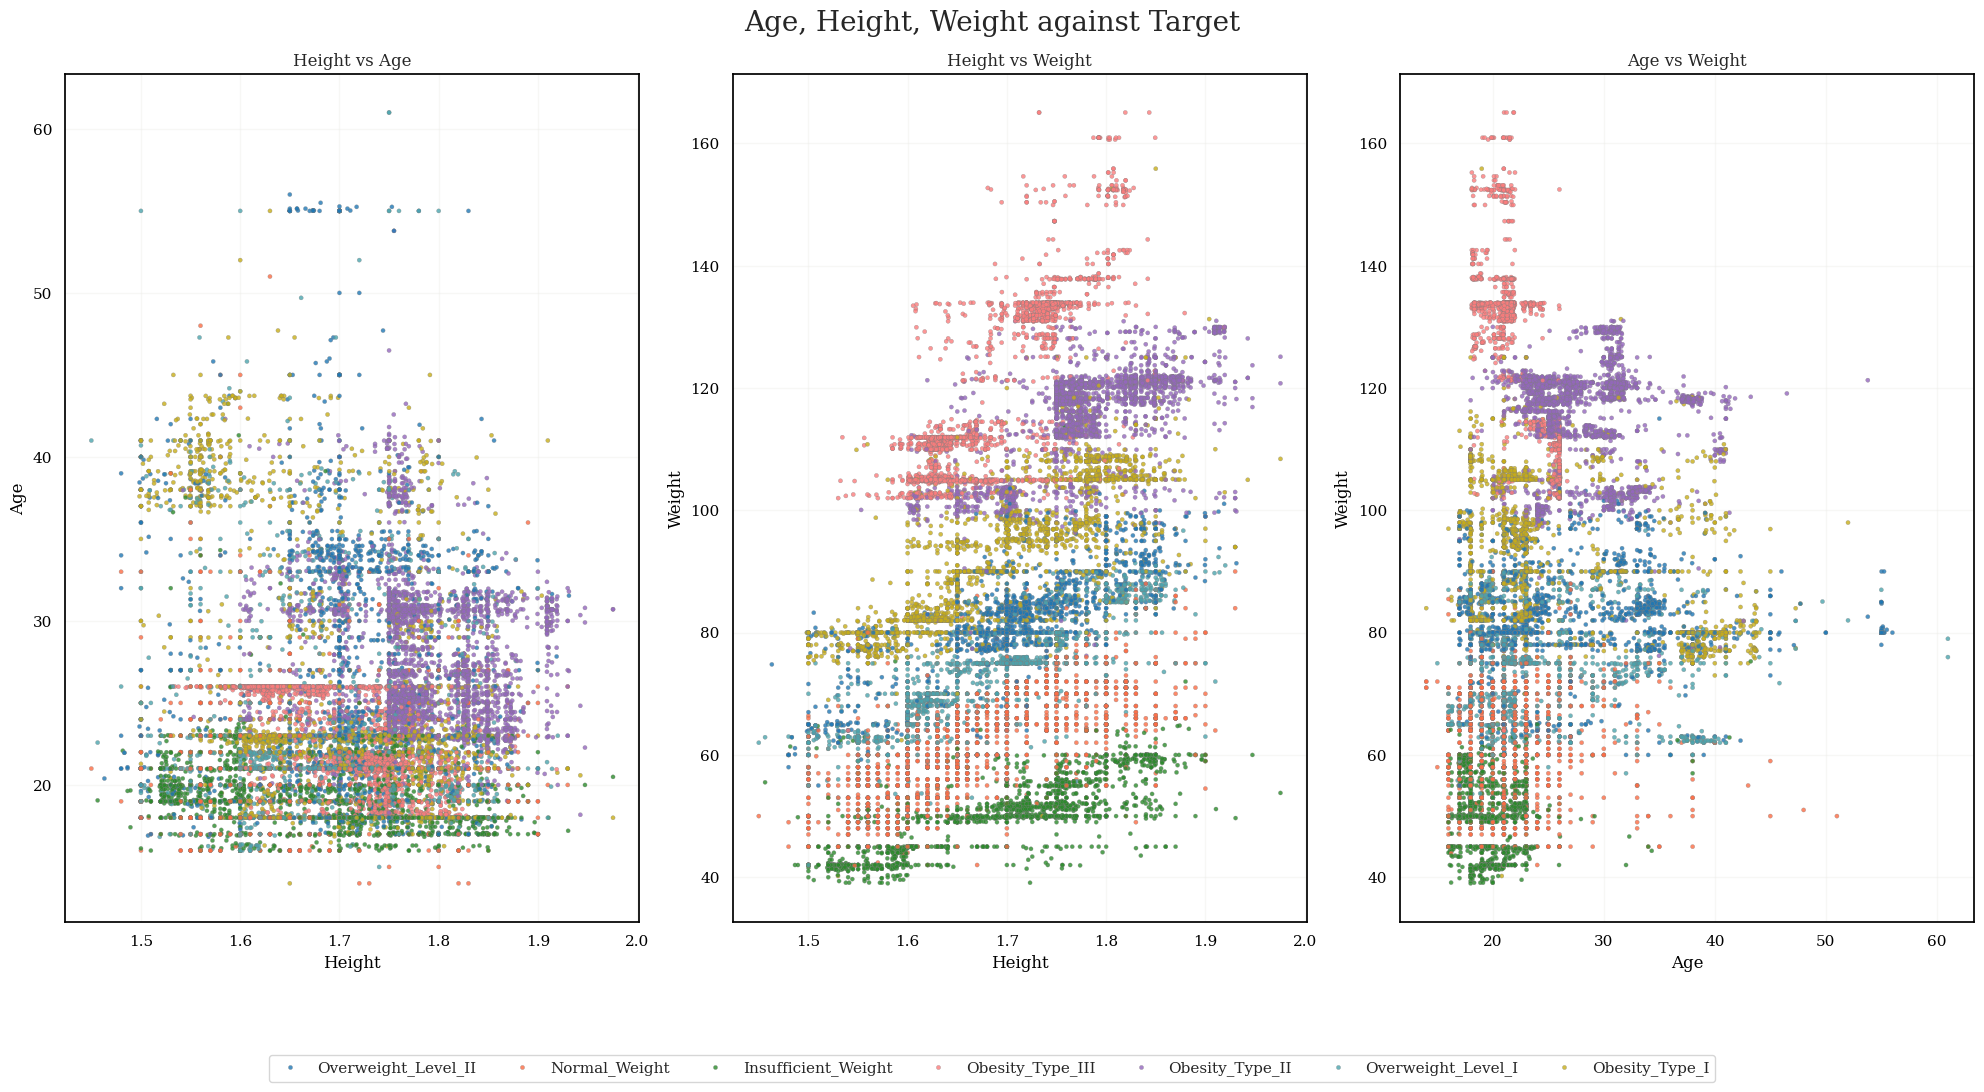

In [133]:
# Visualizing Features with target variable
colors=['#1f77b4', '#fc6c44', '#2b8a2b', '#fc7c7c', '#9467bd', '#4ba4ad', '#c7ad18', '#7f7f7f', '#69d108']
fig,axes=plt.subplots(1,3,figsize=(20,10))
ax1=sns.scatterplot(x=df_train['Height'],
                    y=df_train['Age'],
                    hue=df_train.columns[-1],
                    data=df_train,
                    palette=colors,
                    edgecolor='grey',
                    alpha=0.8,
                    s=9,
                    ax=axes[0])
axes[0].set_title("Height vs Age")

ax2=sns.scatterplot(x=df_train['Height'],
                    y=df_train['Weight'],
                    hue=df_train.columns[-1],
                    data=df_train,
                    palette=colors,
                    edgecolor='grey',
                    alpha=0.8,
                    s=9,
                    ax=axes[1])
axes[1].set_title("Height vs Weight")

ax3=sns.scatterplot(x=df_train['Age'],
                    y=df_train['Weight'],
                    hue=df_train.columns[-1],
                    data=df_train,
                    palette=colors,
                    edgecolor='grey',
                    alpha=0.8,
                    s=9,
                    ax=axes[2])
axes[2].set_title("Age vs Weight")

for ax in axes.flatten():
    ax.get_legend().remove()

handles,labels=ax1.get_legend_handles_labels() # handles; list of artist objects (lines,markers)
                                            #labels; What each handle repesents
fig.legend(handles,
           labels,
           loc="lower center",
           bbox_to_anchor=(0.5,-0.1),
           ncol=len(df_train[df_train.columns[-1]].unique()),
           title='')

fig.suptitle('Age, Height, Weight against Target',fontsize=20)
fig.subplots_adjust(bottom=0.5,top=0.9,hspace=0.5)
plt.tight_layout()
plt.show()

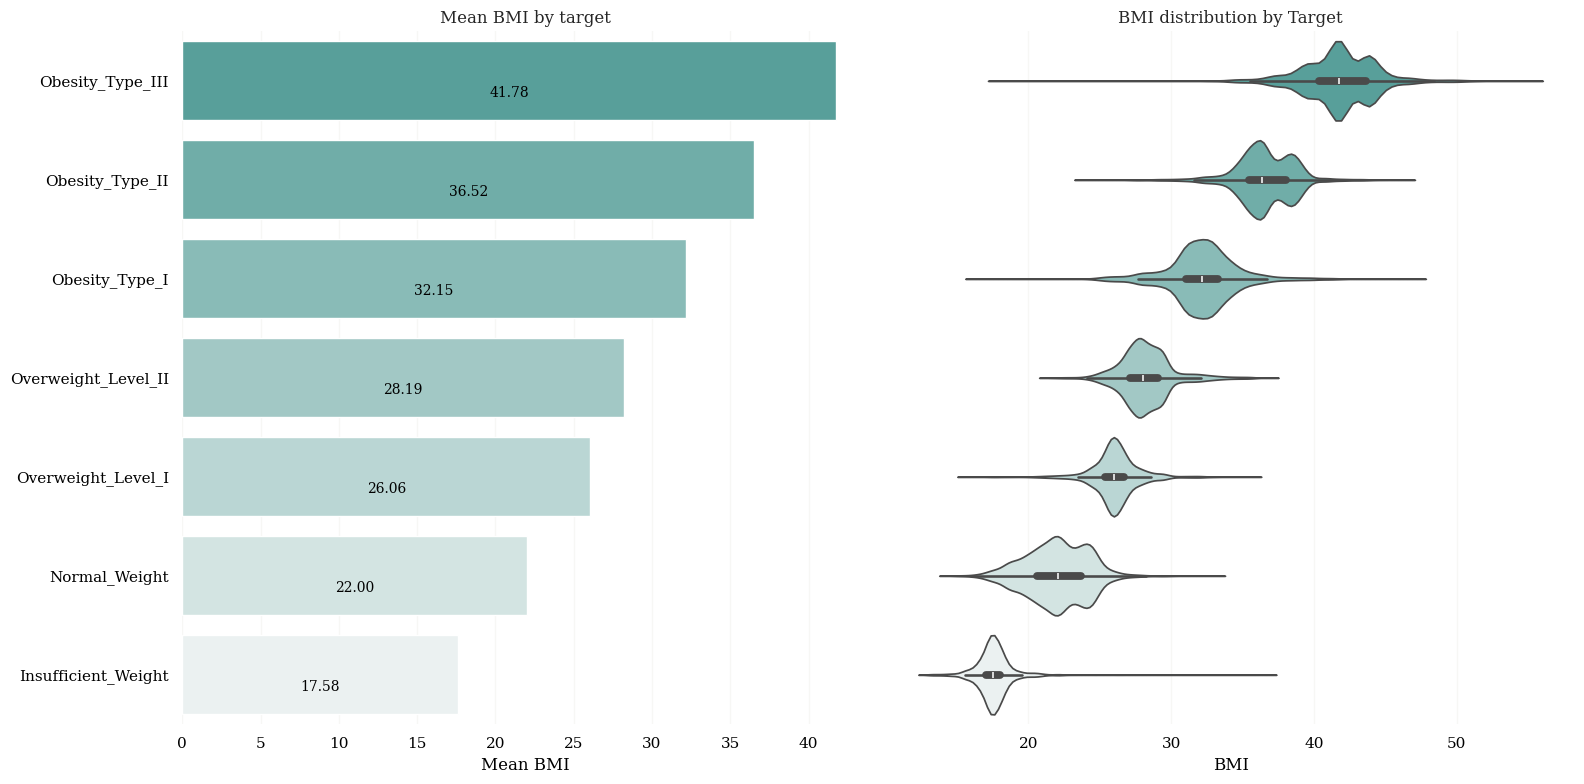

In [134]:
# Lets create BMI as a feature and check it against Target
fig,axes=plt.subplots(1,2,figsize=(16,8))
df_train["BMI"]=df_train["Weight"]/df_train["Height"]**2
ax1=axes[0]
df_sort=df_train.groupby('NObeyesdad')['BMI'].mean().sort_values(ascending=False).index
sns.barplot(x='BMI',
            y="NObeyesdad",
            data=df_train,
            palette='light:#4caba4_r',
            order=df_sort,
            estimator=np.mean, # estimator; function that aggregates the data
            ci=None,           # ci; confidence interval
            errwidth=0,        # errwidth; width of error bars at the end of the cap
            ax=ax1)

for p in ax1.patches: # p is each bar in the plot
    ax1.annotate(f"{p.get_width():.2f}",
                 (p.get_x()+p.get_width()/2,p.get_y()+p.get_height()),
                 ha='center',
                 va='center',
                 xytext=(0,20),
                 textcoords='offset points',
                 fontsize=10,
                 color='black')
ax1.set_title("Mean BMI by target")
ax1.set_xlabel("Mean BMI")
ax1.set_ylabel("")
sns.despine(left=True,bottom=True,ax=ax1)

# violin plot
ax2=axes[1]
sns.violinplot(x="BMI",
               y="NObeyesdad",
               data=df_train,palette='light:#4caba4_r',
               order=df_sort,
               ax=ax2)
ax2.set_title("BMI distribution by Target")
ax2.set_ylabel("")
ax2.set_xlabel("BMI")
plt.yticks([])
sns.despine(left=True,bottom=True,ax=ax2)

plt.tight_layout()
plt.show()

In [135]:
df_train.groupby("NObeyesdad")["BMI"].describe().reset_index()

,NObeyesdad,count,mean,std,min,25%,50%,75%,max
0,Insufficient_Weight,"2,523.00",17.58,1.39,12.87,17.03,17.51,18.03,36.78
1,Normal_Weight,"3,082.00",22.00,2.19,14.63,20.57,22.04,23.66,32.88
2,Obesity_Type_I,"2,910.00",32.15,2.51,16.60,31.02,32.12,33.30,46.81
3,Obesity_Type_II,"3,248.00",36.52,2.11,24.05,35.44,36.38,38.02,46.22
4,Obesity_Type_III,"4,046.00",41.78,2.67,18.18,40.37,41.75,43.62,55.00
5,Overweight_Level_I,"2,427.00",26.06,1.77,15.76,25.39,25.96,26.67,35.56
6,Overweight_Level_II,"2,522.00",28.19,1.84,21.51,27.08,28.02,29.09,36.74


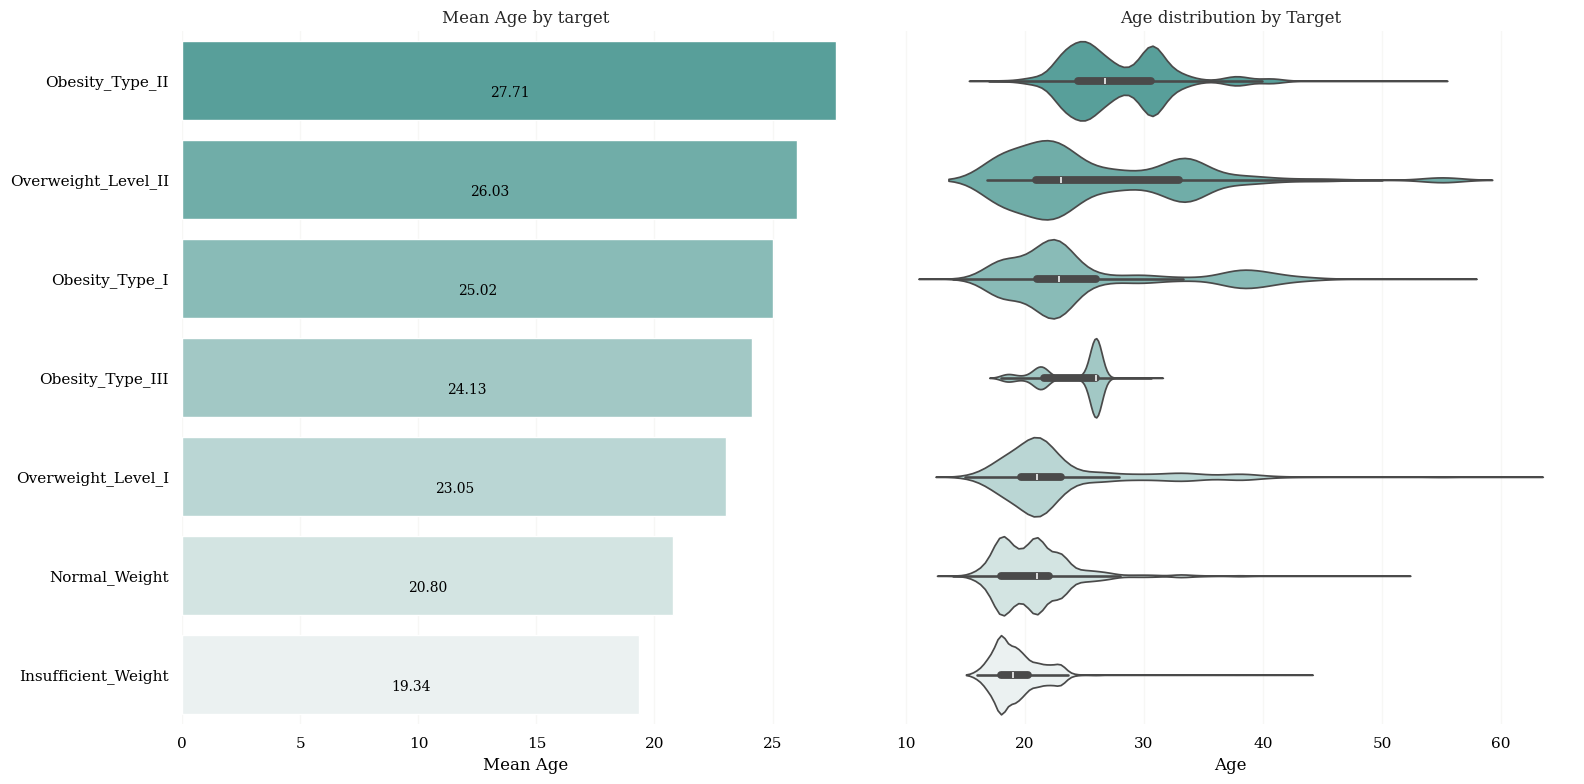

In [136]:
# Lets visualize Age against Target
fig,axes=plt.subplots(1,2,figsize=(16,8))

ax1=axes[0]
df_sort=df_train.groupby('NObeyesdad')['Age'].mean().sort_values(ascending=False).index
sns.barplot(x='Age',
            y="NObeyesdad",
            data=df_train,
            palette='light:#4caba4_r',
            order=df_sort,
            estimator=np.mean, # estimator; function that aggregates the data
            ci=None,           # ci; confidence interval
            errwidth=0,        # errwidth; width of error bars at the end of the cap
            ax=ax1)

for p in ax1.patches: # p is each bar in the plot
    ax1.annotate(f"{p.get_width():.2f}",
                 (p.get_x()+p.get_width()/2,p.get_y()+p.get_height()),
                 ha='center',
                 va='center',
                 xytext=(0,20),
                 textcoords='offset points',
                 fontsize=10,
                 color='black')
ax1.set_title("Mean Age by target")
ax1.set_xlabel("Mean Age")
ax1.set_ylabel("")
sns.despine(left=True,bottom=True,ax=ax1)

# violin plot
ax2=axes[1]
sns.violinplot(x="Age",
               y="NObeyesdad",
               data=df_train,
               palette='light:#4caba4_r',
               order=df_sort,
               ax=ax2)
ax2.set_title("Age distribution by Target")
ax2.set_ylabel("")
ax2.set_xlabel("Age")
plt.yticks([])
sns.despine(left=True,bottom=True,ax=ax2)

plt.tight_layout()
plt.show()

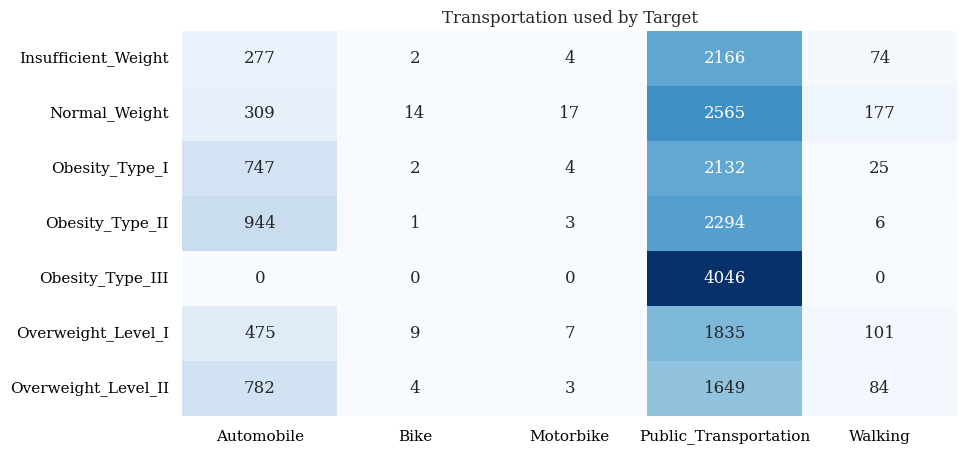

In [137]:
cross_tab=pd.crosstab(df_train["NObeyesdad"],df_train["MTRANS"])
plt.figure(figsize=(10,5))
sns.heatmap(data=cross_tab,annot=True,cmap="Blues",fmt="d",cbar=False)
plt.title("Transportation used by Target")
plt.xlabel('')
plt.ylabel('')
plt.show()

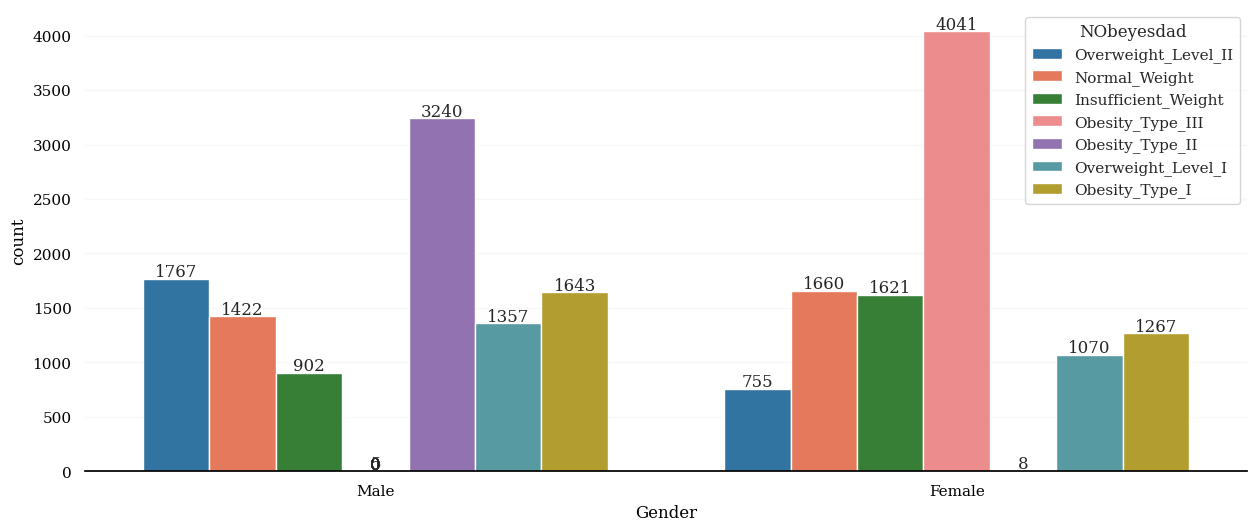

In [138]:
# Distribution of Target across gender
plt.figure(figsize=(15,6))
ax=sns.countplot(data=df_train,
                 x="Gender",
                 hue="NObeyesdad",
                 palette=colors,
                 dodge=True)
sns.despine(left=True,bottom=False)

for p in ax.patches:
    height=p.get_height()
    ax.annotate(f"{round(height)}",
                (p.get_x()+p.get_width()/2,height),
                ha='center',                      
                va='center',
                xytext=(0,5),                           # xytext; coordibates to place the text
                textcoords='offset points')
plt.show()

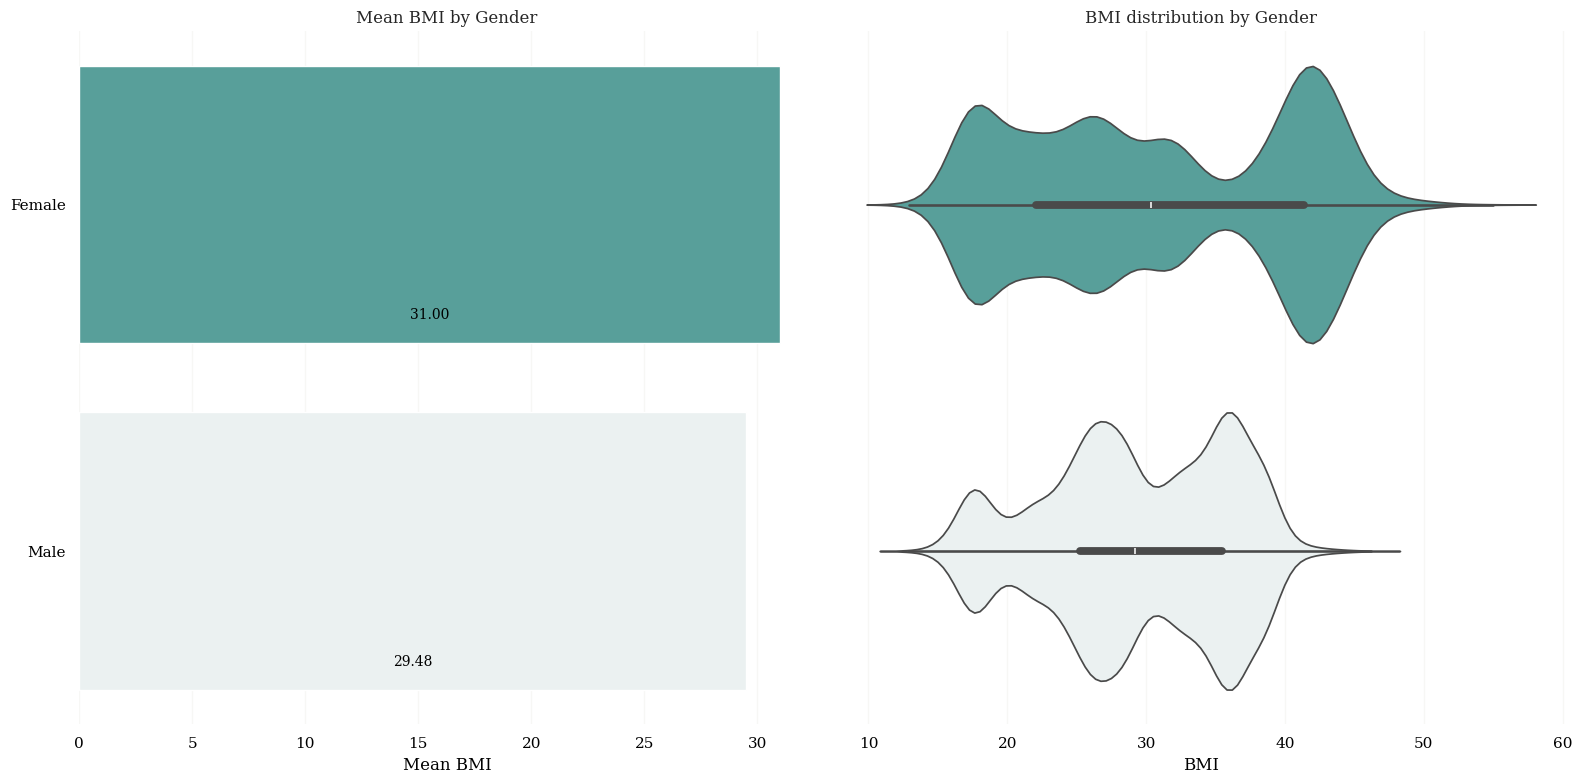

In [139]:
# Lets visualize BMI against Gender
fig,axes=plt.subplots(1,2,figsize=(16,8))

ax1=axes[0]
df_sort=df_train.groupby('Gender')['BMI'].mean().sort_values(ascending=False).index
sns.barplot(x='BMI',
            y="Gender",
            data=df_train,
            palette='light:#4caba4_r',
            order=df_sort,
            estimator=np.mean, # estimator; function that aggregates the data
            ci=None,           # ci; confidence interval
            errwidth=0,        # errwidth; width of error bars at the end of the cap
            ax=ax1)

for p in ax1.patches: # p is each bar in the plot
    ax1.annotate(f"{p.get_width():.2f}",
                 (p.get_x()+p.get_width()/2,p.get_y()+p.get_height()),
                 ha='center',
                 va='center',
                 xytext=(0,20),
                 textcoords='offset points',
                 fontsize=10,
                 color='black')
ax1.set_title("Mean BMI by Gender")
ax1.set_xlabel("Mean BMI")
ax1.set_ylabel("")
sns.despine(left=True,bottom=True,ax=ax1)

# violin plot
ax2=axes[1]
sns.violinplot(x="BMI",
               y="Gender",
               data=df_train,
               palette='light:#4caba4_r',
               order=df_sort,
               ax=ax2)
ax2.set_title("BMI distribution by Gender")
ax2.set_ylabel("")
ax2.set_xlabel("BMI")
plt.yticks([])
sns.despine(left=True,bottom=True,ax=ax2)

plt.tight_layout()
plt.show()

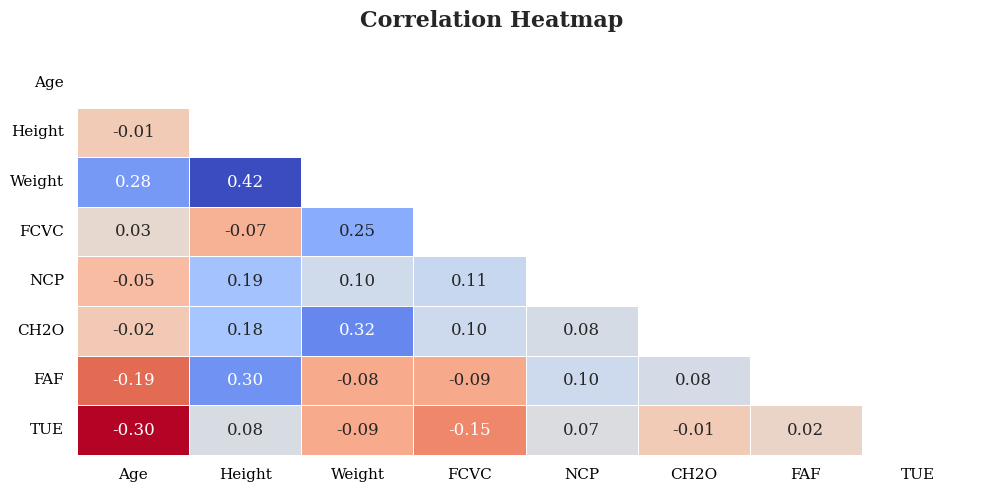

In [140]:
# correlation Heatmap
corr=numeric_columns.corr(method='pearson')
mask=np.triu(np.ones_like(corr))
fig=plt.subplots(figsize=(10,5))
sns.heatmap(data=corr,
            annot=True,
            fmt=".2f",
            cmap='coolwarm_r',
            mask=mask,
            cbar=None,
            linewidth=0.5)
plt.suptitle("Correlation Heatmap",fontsize=16,fontweight="bold")
plt.tight_layout()
plt.show()

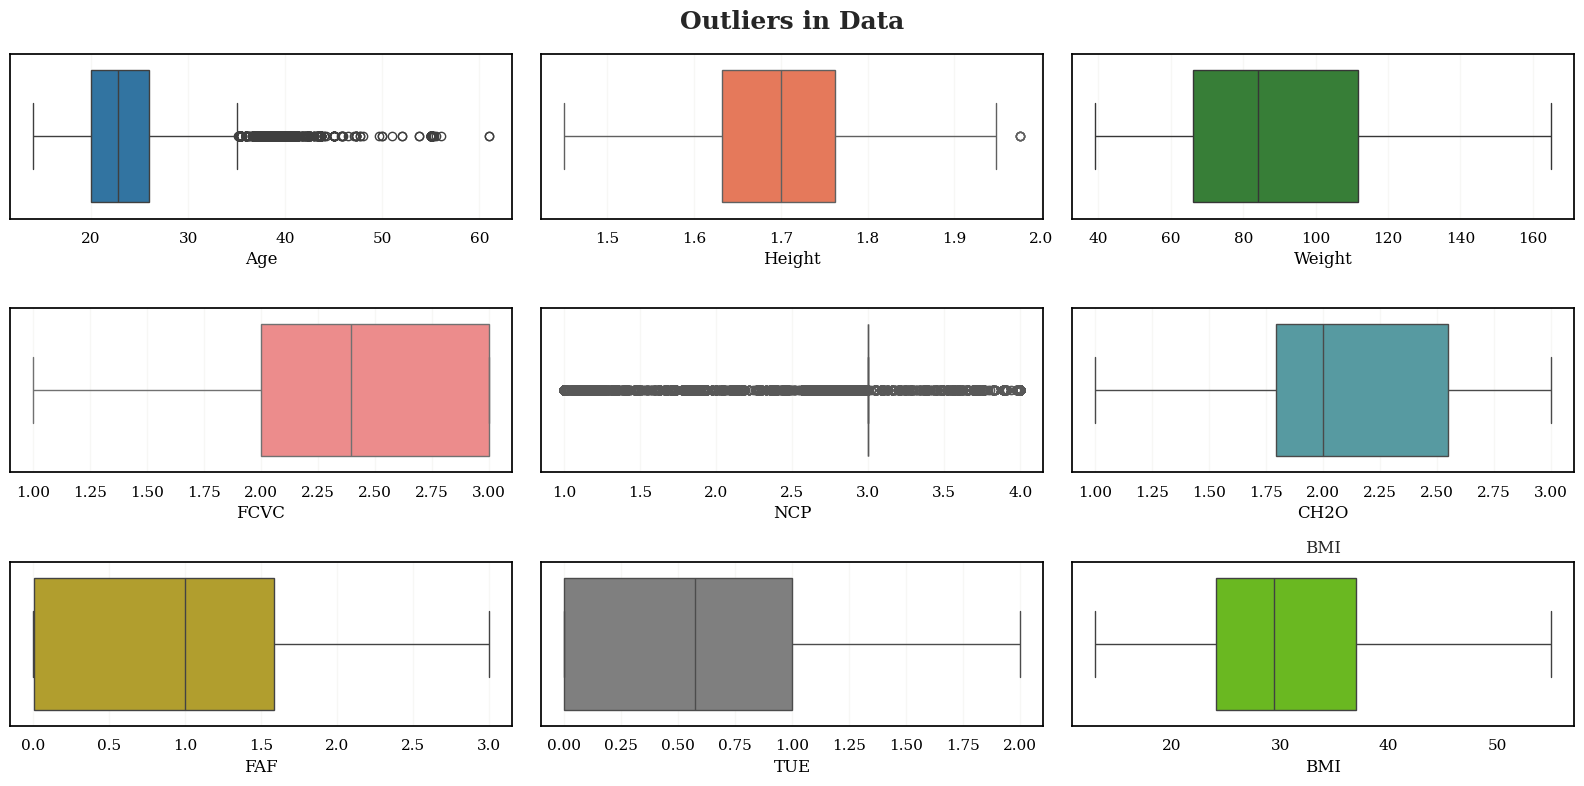

In [141]:
# check for outliers in each feature
numeric_columns=df_train.drop(columns=['id'],axis=1).select_dtypes(include=['float64','int64']).columns

fig=plt.figure(figsize=(16,8))
plt.suptitle("Outliers in Data", fontsize=18,fontweight='bold');
fig.subplots_adjust(top=0.92); # adjust top of the subplot
fig.subplots_adjust(hspace=0.5,wspace=0.5); # adjust the space between subplots
for i,col in enumerate(numeric_columns):
    ax=fig.add_subplot(3,3,i+1); # rows, columns, index
    ax=sns.boxplot(data=df_train,x=col,color=colors[i]);
ax.set_title(col)
ax.set_xlabel(col)
ax.grid(False)
plt.tight_layout()
plt.show()

## Preprocessing


In [142]:
def get_variable_types(df):
    categorical_vars=[]
    continuous_vars=[]
    for col in df.columns:
        if df[col].dtype=='object':
            categorical_vars.append(col)
        else:
            continuous_vars.append(col)
    return categorical_vars, continuous_vars

categorical_vars,continuous_vars=get_variable_types(df_train)
categorical_vars.remove('NObeyesdad')


In [143]:
categorical_vars

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS']

In [144]:
train=pd.concat([df_train,orginal],axis=0).drop(columns=['id','BMI'],axis=1)
test=df_test.drop(columns=['id'],axis=1)

In [145]:
train=pd.get_dummies(train,columns=categorical_vars,drop_first=True) # Drop first to avoid multicolinearity. 
test=pd.get_dummies(test,columns=categorical_vars,drop_first=True)# multicolinearity is when one varibale can be predicted from others

In [146]:
X=train.drop(columns=["NObeyesdad"],axis=1)
y=train["NObeyesdad"]

In [147]:
X.shape

(22869, 23)

In [148]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [149]:

# # Define the objective function for Optuna optimization
# import optuna
# from optuna.samplers import TPESampler
# from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
# skf=StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

# def objective(trial):
#     # Define parameters to be optimized for the LGBMClassifier
#     param = {
#         "objective": "multiclass",
#         "metric": "multi_logloss",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#         "random_state": 42,
#         "num_class": 7,
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
#         "n_estimators": trial.suggest_int("n_estimators", 400, 600),
#         "lambda_l1": trial.suggest_float("lambda_l1", 0.005, 0.015),
#         "lambda_l2": trial.suggest_float("lambda_l2", 0.02, 0.06),
#         "max_depth": trial.suggest_int("max_depth", 6, 14),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
#         "subsample": trial.suggest_float("subsample", 0.8, 1.0),
#         "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
#     }

#  # Create an instance of LGBMClassifier with the suggested parameters
#     lgbm_classifier = LGBMClassifier(**param)
    
# # perform cross validation
#     score=cross_val_score(estimator=lgbm_classifier,X=X,y=y,cv=skf,scoring='accuracy',n_jobs=-1)

#     return score.mean()


# #Set up the sampler for Optuna optimization
# sampler = optuna.samplers.TPESampler(seed=42)  # Using Tree-structured Parzen Estimator sampler for optimization

# # Create a study object for Optuna optimization
# study = optuna.create_study(direction="maximize", sampler=sampler)

# # Run the optimization process
# study.optimize(lambda trial: objective(trial), n_trials=10)

# # Get the best parameters after optimization
# best_params = study.best_params

# print('='*50)
# print(best_params)


In [150]:
# Best parameters obtained from Optuna optimization from notebook in comments
# https://www.kaggle.com/code/moazeldsokyx/pgs4e2-highest-score-lgbm-hyperparameter-tuning/notebook

best_params = {
    "objective": "multiclass",          # Objective function for the model
    "metric": "multi_logloss",          # Evaluation metric
    "verbosity": -1,                    # Verbosity level (-1 for silent)
    "boosting_type": "gbdt",            # Gradient boosting type
    "random_state": 42,       # Random state for reproducibility
    "num_class": 7,                     # Number of classes in the dataset
    'learning_rate': 0.030962211546832760,  # Learning rate for gradient boosting
    'n_estimators': 500,                # Number of boosting iterations
    'lambda_l1': 0.009667446568254372,  # L1 regularization term
    'lambda_l2': 0.04018641437301800,   # L2 regularization term
    'max_depth': 10,                    # Maximum depth of the trees
    'colsample_bytree': 0.40977129346872643,  # Fraction of features to consider for each tree
    'subsample': 0.9535797422450176,    # Fraction of samples to consider for each boosting iteration
    'min_child_samples': 26             # Minimum number of data needed in a leaf
}

In [151]:
lgbm_classfier=LGBMClassifier(**best_params)
lgbm_classfier.fit(X_train,y_train)
y_pred=lgbm_classfier.predict(X_test)
accuracy_score(y_test,y_pred)

0.9062090074333188

In [152]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred))

                     precision    recall  f1-score   support

Insufficient_Weight       0.94      0.93      0.94       585
      Normal_Weight       0.86      0.90      0.88       667
     Obesity_Type_I       0.92      0.88      0.90       670
    Obesity_Type_II       0.97      0.97      0.97       718
   Obesity_Type_III       1.00      1.00      1.00       845
 Overweight_Level_I       0.78      0.78      0.78       531
Overweight_Level_II       0.81      0.82      0.82       558

           accuracy                           0.91      4574
          macro avg       0.90      0.90      0.90      4574
       weighted avg       0.91      0.91      0.91      4574



In [153]:
print(confusion_matrix(y_test,y_pred))

[[542  39   0   0   0   3   1]
 [ 25 598   0   0   0  40   4]
 [  1   1 590  16   0  19  43]
 [  0   0  15 700   0   0   3]
 [  1   0   2   1 841   0   0]
 [  5  48   9   0   0 415  54]
 [  0  11  28   8   0  52 459]]


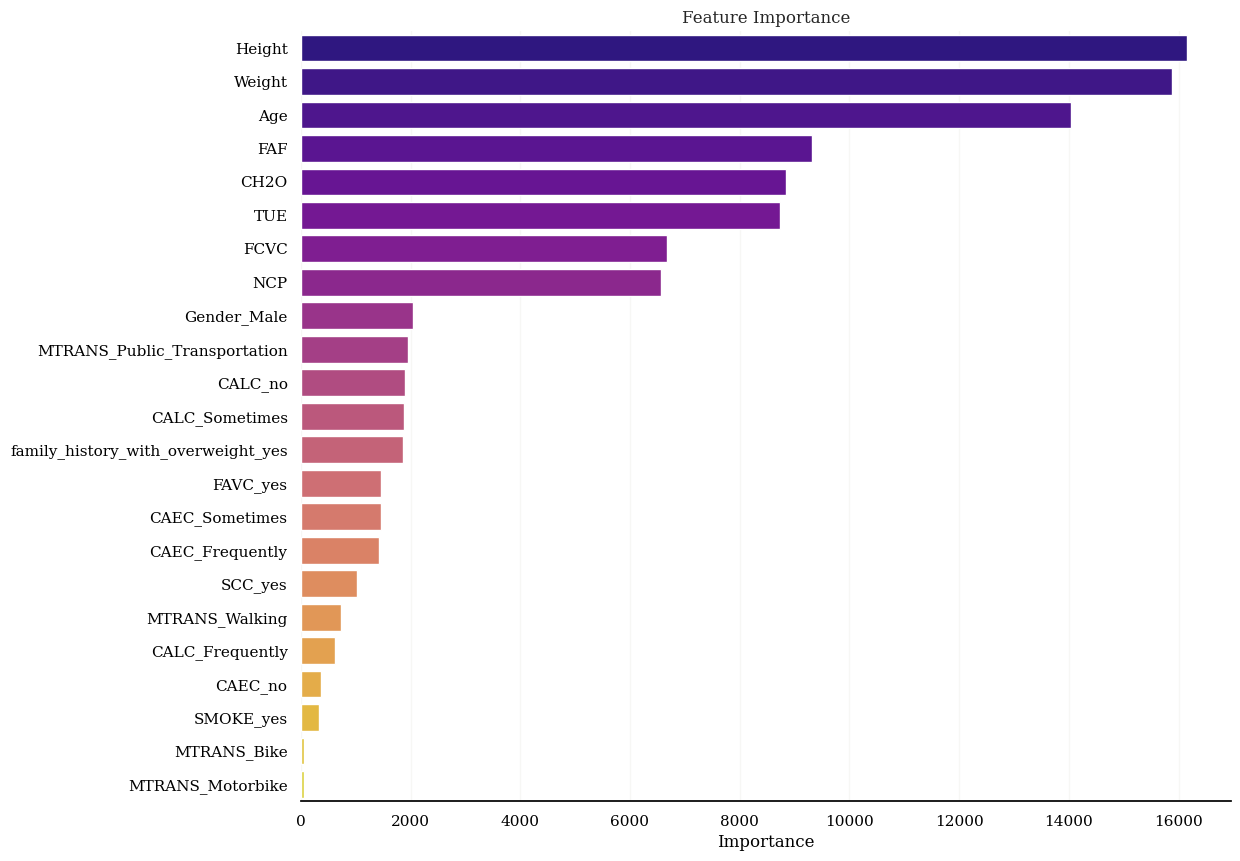

In [163]:
# feature importance
feature_importance=lgbm_classfier.feature_importances_
feature_importance_df=pd.DataFrame({'Features':X.columns,"Importance":feature_importance})
feature_importance_df=feature_importance_df.sort_values(by='Importance',ascending=False)

plt.figure(figsize=(12,10))
sns.barplot(data=feature_importance_df,x="Importance",y="Features",palette='plasma')
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("")
sns.despine(left=True,bottom=False)
plt.show()